**Thinkful - Challenge 2.2.7 - Feedback Analysis**

Guided Example - For Reference (Note: total number of mislabeled points does not change when 'all caps' filter is removed)

Number of mislabeled points out of a total 5572 points : 604
Percent points mislabeled : 11.0


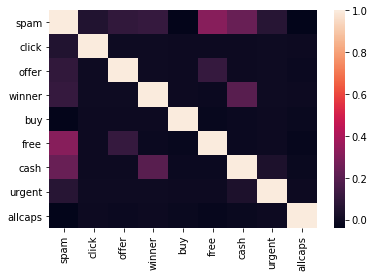

In [175]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Grab and process the raw data.
#data_path = (spam.txt)
sms_raw = pd.read_csv('spam.txt', delimiter= '\t', header=None)
sms_raw.columns = ['spam', 'message']

keywords = ['click', 'offer', 'winner', 'buy', 'free', 'cash', 'urgent']

for key in keywords:
    # Note that we add spaces around the key so that we're getting the word, not just pattern matching.
    sms_raw[str(key)] = sms_raw.message.str.contains(' ' + str(key) + ' ',case=False)

sms_raw['allcaps'] = sms_raw.message.str.isupper()

sms_raw['spam'] = (sms_raw['spam'] == 'spam')

sns.heatmap(sms_raw.corr())

data = sms_raw[keywords + ['allcaps']]
target = sms_raw['spam']

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(data.shape[0],(target != y_pred).sum()))
print("Percent points mislabeled : {}".format(round((target != y_pred).sum()*100/data.shape[0]),2))

**Count unique words - Using Dictionaries**

To determine which words might be best suited for identifying negative reviews, I first created a dictionary of all the words in the reviews and counted the number of times each word was used in a review (not case-sensitive).

In [59]:
with open('amazon_cells_labelled.txt') as f:
    c = collections.Counter(f.read().lower().split())

print(c)

Counter({'the': 513, '1': 503, '0': 500, 'i': 313, 'and': 310, 'is': 238, 'it': 237, 'a': 217, 'this': 197, 'to': 195, 'my': 143, 'of': 119, 'for': 119, 'phone': 118, 'not': 115, 'with': 107, 'very': 102, 'was': 90, 'in': 87, 'on': 87, 'that': 75, 'have': 72, 'good': 66, 'great': 63, 'you': 62, 'but': 45, 'as': 45, 'had': 43, 'works': 43, 'so': 42, 'are': 41, 'battery': 39, 'sound': 35, 'has': 34, 'all': 34, 'one': 34, 'quality': 33, 'from': 33, 'phone.': 33, 'headset': 32, 'would': 32, 'your': 32, 'it.': 31, 'like': 30, 'if': 29, "don't": 28, "i've": 28, 'than': 28, 'product': 27, 'after': 27, 'use': 27, "it's": 27, 'be': 26, 'really': 26, 'no': 26, 'at': 24, '-': 24, 'recommend': 24, 'does': 23, 'or': 23, 'work': 23, "i'm": 22, 'get': 22, 'when': 22, 'only': 22, 'just': 21, 'up': 21, 'product.': 21, 'excellent': 21, 'love': 20, 'any': 20, 'well': 20, 'am': 20, 'out': 20, 'also': 19, '2': 19, 'nice': 19, 'an': 19, 'best': 19, 'do': 19, 'ear': 19, 'me': 19, 'can': 18, 'these': 18, 'bet

**Count words and output average review per word - Using Lists**

Generating a list of words and how frequently they were used was marginally helpful because the words which were used most frequently were 'the','and','is','it' and 'a', which could easily be used in either positive or negative reviews. For the purposes of training the model, I needed to use words which were either strongly associated with positive reviews or with negative reviews. To identify which words this had strong associations, I calculated the average review score for each word. Words that were closer to 1 had a positive association, and words that were closer to 0 had a negative association. This information was somewhat helpful, but there could be words that were used only once, meaning that they would have a strong positive or negative association, but would not be useful for sorting purposes. Ideal words for training the model would be used frequently AND had strong associations. Thus, I generated a metric called "Positive Word Score" for each word, which is the product of the average review score and the number of times that the word was used. After sorting out only word scores with strong associations (>0.8), I used the highest the top 20 words scores to train the model. This process was repeated for "Negative Word Score" as well.

In [103]:
import pandas as pd
import re

df = pd.read_csv('amazon_cells_labelled.txt',delimiter="\t")
df.columns = ['Review', 'Score']
Review = df['Review']
Score = df['Score']

#Put words and scores into list
wordList = []
lineScore = []
line = []
for i in range(len(Review)):
    line = re.findall(r"[\w']+", Review[i].lower())
    for word in range(len(line)):
        wordList.append(line[word])
        lineScore.append(Score[i])
        
df2 = pd.DataFrame(list(zip(wordList, lineScore)),columns=['List','Score'])

#Create list of unique words, count frequency, and calculate average review
df3 = df2.groupby('List')['Score'].agg(['count','mean']).reset_index()
count = df3['count']
mean = df3['mean']

#Create list of unique words associated with positive reviews
PositiveWordScore = []
for i in range(len(df3['List'])):
    PositiveWordScore.append(count[i]*mean[i])

df3['Pos Word Score'] = pd.Series(PositiveWordScore, index=df3.index)
df4 = df3.sort_values('Pos Word Score', ascending=False)
df5 = df4.loc[df4['mean'] > 0.8]
print(df5.iloc[:20])

#Create list of unique words associated with negative reviews
NegativeWordScore = []
for i in range(len(df3['List'])):
    a = 1 - mean[i]
    NegativeWordScore.append(count[i]*a)

df3['Neg Word Score'] = pd.Series(NegativeWordScore, index=df3.index)
df4 = df3.sort_values('Neg Word Score', ascending=False)
df5 = df4.loc[df4['mean'] < 0.3]
print(df5.iloc[:20])

             List  count      mean  Pos Word Score
731         great     99  0.949495            94.0
725          good     77  0.831169            64.0
1854        works     47  0.978723            46.0
1805         well     42  0.833333            35.0
579     excellent     27  0.962963            26.0
1258        price     27  0.925926            25.0
1086         nice     22  1.000000            22.0
181          best     23  0.913043            21.0
980          love     20  1.000000            20.0
533          easy     18  0.833333            15.0
329   comfortable     17  0.823529            14.0
751         happy     15  0.866667            13.0
636          fine     13  0.923077            12.0
312         clear     12  0.833333            10.0
642          fits     11  0.909091            10.0
1853      working     11  0.818182             9.0
777        highly      9  0.888889             8.0
1867        years      9  0.888889             8.0
878         jabra      8  0.875

**Using positive and negative keywords from previous step with guided example to predict score of Amazon Review**

At first I trained the model with only positive keywords, and the total number of mislabeled points was 326. After adding the top 20 words with negative associations, the number of mislabeled points was reduced to 320, which indicates that the negative keywords have weaker associations.

0.67967967968
Number of mislabeled points out of a total 999 points : 320
Percent points mislabeled : 32.0


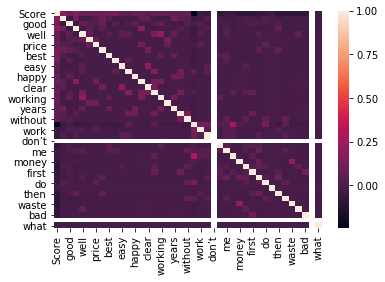

In [182]:
# Grab and process the raw data.
df = pd.read_csv('amazon_cells_labelled.txt',delimiter="\t")
df.columns = ['Review', 'Score']
 
keywords = ['great','good','works','well','excellent','price','nice','best','love',
            'easy','comfortable','happy','fine','clear','fits','working','highly','years',
            'jabra', 'without','not','work','if','don’t','after','me','does','money','only',
            'first','out','do','poor','then','buy','waste','worst','bad','doesn’t','what']

for key in keywords:
    # Note that we add spaces around the key so that we're getting the word, not just pattern matching.
    df[str(key)] = df.Review.str.contains(' ' + str(key) + ' ',case=False)

sns.heatmap(df.corr())

data = df[keywords]
target = df['Score']

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)
print(bnb.score(data,target))

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(data.shape[0],(target != y_pred).sum()))
print("Percent points mislabeled : {}".format(round((target != y_pred).sum()*100/data.shape[0]),2))

**Using positive and negative keywords from previous step with guided example to predict score of Yelp Review**

38% of the points were mislabeled using the keywords from the Amazon review to evaluate the Yelp Review. This makes sense, as the Yelp reviewers may have different things to comment on, such as how the food tasted or the business hours, which would not have been evaluated in the Amazon review.

Number of mislabeled points out of a total 999 points : 382
Percent points mislabeled : 38.0


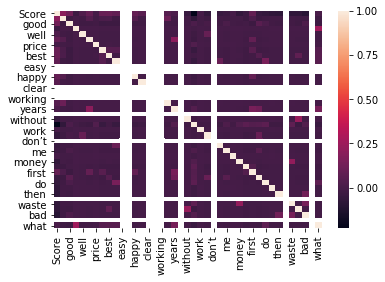

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Grab and process the raw data.
df = pd.read_csv('yelp_labelled.txt',delimiter="\t")
df.columns = ['Review', 'Score']
 
keywords = ['great','good','works','well','excellent','price','nice','best','love',
            'easy','comfortable','happy','fine','clear','fits','working','highly','years',
            'jabra', 'without','not','work','if','don’t','after','me','does','money','only',
            'first','out','do','poor','then','buy','waste','worst','bad','doesn’t','what']

for key in keywords:
    # Note that we add spaces around the key so that we're getting the word, not just pattern matching.
    df[str(key)] = df.Review.str.contains(' ' + str(key) + ' ',case=False)

sns.heatmap(df.corr())

data = df[keywords]
target = df['Score']

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(data.shape[0],(target != y_pred).sum()))
print("Percent points mislabeled : {}".format(round((target != y_pred).sum()*100/data.shape[0]),2))

**Using positive and negative keywords from previous step with guided example to predict score of IMDB Review**

39% of the points were mislabeled using the keywords from the Amazon review to evaluate the IMDB Review. This makes sense, as the IMDB reviewers may have different things to comment on, such as the movie plot and character performance, which would not have been evaluated in the Amazon review.

Number of mislabeled points out of a total 747 points : 291
Percent points mislabeled : 39.0


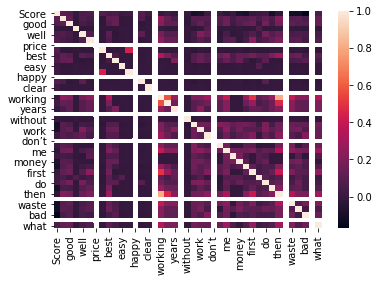

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Grab and process the raw data.
df = pd.read_csv('imdb_labelled.txt',delimiter="\t")
df.columns = ['Review', 'Score']
 
keywords = ['great','good','works','well','excellent','price','nice','best','love',
            'easy','comfortable','happy','fine','clear','fits','working','highly','years',
            'jabra', 'without','not','work','if','don’t','after','me','does','money','only',
            'first','out','do','poor','then','buy','waste','worst','bad','doesn’t','what']

for key in keywords:
    # Note that we add spaces around the key so that we're getting the word, not just pattern matching.
    df[str(key)] = df.Review.str.contains(' ' + str(key) + ' ',case=False)

sns.heatmap(df.corr())

data = df[keywords]
target = df['Score']

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(data.shape[0],(target != y_pred).sum()))
print("Percent points mislabeled : {}".format(round((target != y_pred).sum()*100/data.shape[0]),2))